<a href="https://colab.research.google.com/github/talhaanwarch/Plant-Leaf-Disease-Classification/blob/master/transfer_learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip

--2020-03-30 10:57:43--  https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86, 2606:4700:7::a29f:8256, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb [following]
--2020-03-30 10:57:48--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.104.179
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.104.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66977095 (64

In [0]:
!pip install efficientnet

In [0]:
!unzip /content/Citrus.zip

Archive:  /content/Citrus.zip
   creating: Citrus/
   creating: Citrus/Fruits/
   creating: Citrus/Fruits/Black spot/
  inflating: Citrus/Fruits/Black spot/Black spot (1).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (10).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (11).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (12).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (13).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (14).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (15).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (16).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (17).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (18).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (19).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (2).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (3).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (4).jpg  
  inflating: Citrus/Fruits/Black spot/Black sp

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [0]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.2)

In [0]:
img_shape=300
batch_size=16

In [0]:
#load the training data
train_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)


Found 490 images belonging to 5 classes.


In [0]:
#load the training data
val_suffle=False
val_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=16,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350


Found 119 images belonging to 5 classes.


In [0]:
train_generator.next()[0].shape,train_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [0]:
val_generator.next()[0].shape,val_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf

In [0]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB4(weights = 'imagenet', include_top=False, input_shape = (img_shape,img_shape,3))


71892992/71892840 [==============================] - 3s 0us/step


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [0]:
results = model.fit(train_generator,epochs=10,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)])

Epoch 1/10
31/30 [==============================] - 24s 767ms/step - loss: 1.0140 - accuracy: 0.7122 - val_loss: 1.2439 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 2/10
31/30 [==============================] - 21s 677ms/step - loss: 0.7134 - accuracy: 0.8673 - val_loss: 1.1497 - val_accuracy: 0.6303 - lr: 0.0010
Epoch 3/10
31/30 [==============================] - 21s 678ms/step - loss: 0.6225 - accuracy: 0.9000 - val_loss: 1.6805 - val_accuracy: 0.4874 - lr: 0.0010
Epoch 4/10
31/30 [==============================] - 21s 681ms/step - loss: 0.6050 - accuracy: 0.9020 - val_loss: 1.0457 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/10
31/30 [==============================] - 21s 672ms/step - loss: 0.5792 - accuracy: 0.9163 - val_loss: 1.0041 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 6/10
31/30 [==============================] - 21s 669ms/step - loss: 0.6209 - accuracy: 0.8980 - val_loss: 0.9795 - val_accuracy: 0.6723 - lr: 0.0010
Epoch 7/10
31/30 [==============================] - 21s 677ms/st

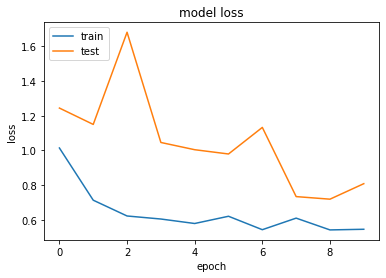

In [0]:
import matplotlib.pyplot as plt

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

7/7 [==============================] - 2s 344ms/step - loss: 0.7211 - accuracy: 0.8738


[0.7210829854011536, 0.8737863898277283]

In [0]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

7/7 [==============================] - 3s 370ms/step - loss: 0.7691 - accuracy: 0.8661


[0.7691188454627991, 0.8660714030265808]

In [0]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

8/7 [================================] - 3s 340ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [0]:
y_pred.shape,y_true.shape

((119,), (119,))

In [0]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8319327731092437
0.8508798447928883


In [0]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.83      0.85      0.84        34
    Melanose       1.00      1.00      1.00         2
      canker       0.91      0.66      0.76        32
    greening       0.84      0.93      0.88        40
     healthy       0.67      0.91      0.77        11

    accuracy                           0.83       119
   macro avg       0.85      0.87      0.85       119
weighted avg       0.84      0.83      0.83       119



# Similar task transfer learning

In [33]:
!wget  https://www.kaggleusercontent.com/kf/30290935/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..CnWcjMaHIojIoLiToJ_z7g.bMyUQKLh7SxAiQmdnnw0jwD7w2PMmLCyhOH-WLGGXEYW32-YOFcM_AUBS1QE-4n93CKGY6Fp6jhepmmAAsm36j2faNBiHi0dwgC5WBcEziy0ztZ1Elg_1Bq960LfUu-Gpnp6eCkEJfcaYkHXT4-ORxWX-ImEwkez8EXqpBo85cJxPrnBXvkJ-RAY_2wZCU2uG0LAxROMP7MpeGlVPsniDunU6lgr5fpyCUfSZE7oPDAYIAqpozYg6EMYvWvBeBrwxQlgdx6UOHPus1h_LBJuZy0-Cb188nw1pPHui7fbPvi7TJshclfGKRCpJiajwLmwlfXhojYJZc41AWOHBPjdlgvgwQ24oWPIS4ybodmXc9kpEUCIw6Z3sAT05Kvm6r4rpJRKcVIQ9Mek7RY3Nrmg36uGBCkUNkd97zf4lRB1ESzpLTPI7CAoBA0MYoMDyh4BJRiXnJs5wWDIthm6J7KD_NKQbseIM59IrdU1sLIj0UAOSxn1LOolAoRf0gqVQwBoUKieIlQHGHJGkiZKfBf2QDE2YBIx-AVdcsFIPccHTqM46NcZyW7xfPNx9aoHB4mf9acU4f20MOzTxAdK3jqDR1UX7-P5ccU2kG_Odeei56sALVg9CQYa3D4XU5ttSbinlnDHwz7wlQUfitIErOqPn2ei4WwFWj8hYQjSkWrzdMU.Hy6STI12LR25Uf4WE3ZQFg/model.h5

--2020-03-30 11:12:34--  https://www.kaggleusercontent.com/kf/30290935/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..CnWcjMaHIojIoLiToJ_z7g.bMyUQKLh7SxAiQmdnnw0jwD7w2PMmLCyhOH-WLGGXEYW32-YOFcM_AUBS1QE-4n93CKGY6Fp6jhepmmAAsm36j2faNBiHi0dwgC5WBcEziy0ztZ1Elg_1Bq960LfUu-Gpnp6eCkEJfcaYkHXT4-ORxWX-ImEwkez8EXqpBo85cJxPrnBXvkJ-RAY_2wZCU2uG0LAxROMP7MpeGlVPsniDunU6lgr5fpyCUfSZE7oPDAYIAqpozYg6EMYvWvBeBrwxQlgdx6UOHPus1h_LBJuZy0-Cb188nw1pPHui7fbPvi7TJshclfGKRCpJiajwLmwlfXhojYJZc41AWOHBPjdlgvgwQ24oWPIS4ybodmXc9kpEUCIw6Z3sAT05Kvm6r4rpJRKcVIQ9Mek7RY3Nrmg36uGBCkUNkd97zf4lRB1ESzpLTPI7CAoBA0MYoMDyh4BJRiXnJs5wWDIthm6J7KD_NKQbseIM59IrdU1sLIj0UAOSxn1LOolAoRf0gqVQwBoUKieIlQHGHJGkiZKfBf2QDE2YBIx-AVdcsFIPccHTqM46NcZyW7xfPNx9aoHB4mf9acU4f20MOzTxAdK3jqDR1UX7-P5ccU2kG_Odeei56sALVg9CQYa3D4XU5ttSbinlnDHwz7wlQUfitIErOqPn2ei4WwFWj8hYQjSkWrzdMU.Hy6STI12LR25Uf4WE3ZQFg/model.h5
Resolving www.kaggleusercontent.com (www.kaggleusercontent.com)... 35.190.26.106
Connecting to www.kaggleusercontent.com (www.kaggleuserconte

In [0]:
transfer_model =efn.EfficientNetB4(weights = None, include_top=False, input_shape = (img_shape,img_shape,3))
x1 = transfer_model.output
print(x1.shape)
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(64, activation="relu")(x1)
transfer_predictions = Dense(4, activation="softmax")(x1)
transfer_model = Model(inputs=transfer_model.input, outputs=transfer_predictions)
transfer_model.load_weights('model.h5')

In [0]:

for layer in transfer_model.layers[:-4]:
    layer.trainable = False


In [0]:
transfer_model2 = Model(transfer_model.input, transfer_model.layers[-5].output)
x1 = transfer_model2.output
print(x1.shape)
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(64, activation="relu")(x1)
transfer_predictions = Dense(5, activation="softmax")(x1)
transfer_model2 = Model(inputs=transfer_model2.input, outputs=transfer_predictions)


In [0]:

for layer in transfer_model2.layers[:-4]:
    layer.trainable = False


In [0]:
transfer_model2.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [0]:
results = transfer_model2.fit_generator(train_generator,epochs=15,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)])